<a href="https://colab.research.google.com/github/un1qqe/Brain-Tumor-Classification/blob/main/image_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-03 18:20:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-03 18:20:43 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from helper_functions import unzip_data,walk_through_dir

In [ ]:
unzip_data('/content/tumordataset.zip')

In [ ]:
train_yes_dir='/content/tumordataset/train/yes/'
test_yes_dir='/content/tumordataset/test/yes/'
train_no_dir='/content/tumordataset/train/no/'
test_no_dir='/content/tumordataset/test/no/'
pred_dir='/content/tumordataset/pred'

In [ ]:
walk_through_dir(test_yes_dir)

There are 0 directories and 499 images in '/content/tumordataset/test/yes/'.


In [ ]:
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
import os
import random

In [ ]:
def view_img(filepath):
  random_img=random.choice(os.listdir(filepath))
  img=plt.imread(filepath+'/'+random_img)
  view=plt.imshow(img)
  plt.axis(False)
  return view,img.shape

(<matplotlib.image.AxesImage at 0x78b08505dd20>, (249, 200, 3))

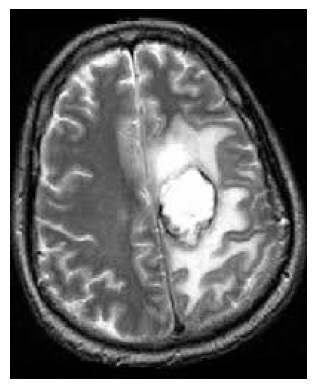

In [ ]:
view_img(pred_dir)

In [ ]:

datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=15,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              brightness_range=[0.5, 1.5],
                              horizontal_flip=True,
                              vertical_flip=True,)

train_generator = datagen.flow_from_directory(
    '/content/tumordataset/train',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary')

Found 2002 images belonging to 2 classes.


In [ ]:
test_generator=datagen.flow_from_directory(
    '/content/tumordataset/test',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

Found 998 images belonging to 2 classes.


In [ ]:
def preprocess(filepath):
  images=[]
  for img_name in os.listdir(filepath):
    img_path=os.path.join(filepath,img_name)
    img=tf.io.read_file(img_path)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.resize(img,(224,224))
    img=tf.cast(img,tf.float32)/255.0
    images.append(img)
  return tf.convert_to_tensor(images)

In [ ]:
pred_data=preprocess(pred_dir)


In [ ]:

class_indices = train_generator.class_indices
print(class_indices)

{'no': 0, 'yes': 1}


In [ ]:
len(train_generator)

63

In [ ]:
train_data=tf.data.Dataset.from_generator(lambda:train_generator,
                                          output_signature=(
    tf.TensorSpec(shape=(None,224,224,3),dtype=tf.float32),
    tf.TensorSpec(shape=(None,),dtype=tf.float32)
    ))
test_data=tf.data.Dataset.from_generator(lambda:test_generator,
                                         output_signature=(
                                             tf.TensorSpec(shape=(None,224,224,3),dtype=tf.float32),
                                             tf.TensorSpec(shape=(None,),dtype=tf.float32)
                                         ))
train_data=train_data.prefetch(tf.data.AUTOTUNE)
test_data=test_data.prefetch(tf.data.AUTOTUNE)

In [ ]:
pred_data=tf.data.Dataset.from_tensor_slices(pred_data)

In [ ]:
pred_data=pred_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
pred_data

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
def vgg16(input_shape=(224, 224, 3), num_classes=1):
  input_tensor=layers.Input(shape=input_shape,dtype=tf.float32)

  #Block 1
  x=Conv2D(64,(3,3),activation='relu',padding='same')(input_tensor)
  x=Conv2D(64,(3,3),activation='relu',padding='same')(x)
  x=MaxPooling2D((2,2),strides=(2,2))(x)

  #Block 2

  x=Conv2D(128,(3,3),activation='relu',padding='same')(x)
  x=Conv2D(128,(3,3),activation='relu',padding='same')(x)
  x=MaxPooling2D((2,2),strides=(2,2))(x)

  #Block 3

  x=Conv2D(256,(3,3),activation='relu',padding='same')(x)
  x=Conv2D(256,(3,3),activation='relu',padding='same')(x)
  x=Conv2D(256,(3,3),activation='relu',padding='same')(x)
  x=MaxPooling2D((2,2),strides=(2,2))(x)

  #Block 4

  x=Conv2D(512,(3,3),activation='relu',padding='same')(x)
  x=Conv2D(512,(3,3),activation='relu',padding='same')(x)
  x=Conv2D(512,(3,3),activation='relu',padding='same')(x)
  x=MaxPooling2D((2,2),strides=(2,2))(x)

  #Block 5

  x=Conv2D(512,(3,3),activation='relu',padding='same')(x)
  x=Conv2D(512,(3,3),activation='relu',padding='same')(x)
  x=Conv2D(512,(3,3),activation='relu',padding='same')(x)
  x=MaxPooling2D((2,2),strides=(2,2))(x)

  #Fully connected layers
  x=Flatten()(x)
  x=Dense(4096,activation='relu')(x)
  x=Dropout(0.5)(x)
  x=Dense(4096,activation='relu')(x)
  x=Dropout(0.5)(x)
  output=Dense(num_classes,activation='sigmoid')(x)
  model=tf.keras.models.Model(inputs=input_tensor,outputs=output)
  return model

In [ ]:
vgg_model=vgg16()

In [ ]:
vgg_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_237 (Conv2D)         (None, 224, 224, 64)      1792      
                                                                 
 conv2d_238 (Conv2D)         (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_91 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_239 (Conv2D)         (None, 112, 112, 128)     73856     
                                                                 
 conv2d_240 (Conv2D)         (None, 112, 112, 128)     147584    
                                                           

In [ ]:
vgg_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),metrics=['accuracy'])
vgg_model_history=vgg_model.fit(train_generator,epochs=100,validation_data=test_generator,callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=20),
    tf.keras.callbacks.ReduceLROnPlateau(patience=10)
])

Epoch 1/100
63/63 [==============================] - 42s 620ms/step - loss: 0.6941 - accuracy: 0.5255 - val_loss: 0.6911 - val_accuracy: 0.5782 - lr: 1.0000e-04
Epoch 2/100
63/63 [==============================] - 38s 606ms/step - loss: 0.6828 - accuracy: 0.5619 - val_loss: 0.6881 - val_accuracy: 0.5020 - lr: 1.0000e-04
Epoch 3/100
63/63 [==============================] - 40s 625ms/step - loss: 0.6464 - accuracy: 0.6414 - val_loss: 0.7216 - val_accuracy: 0.6854 - lr: 1.0000e-04
Epoch 4/100
63/63 [==============================] - 39s 612ms/step - loss: 0.5817 - accuracy: 0.7003 - val_loss: 0.5734 - val_accuracy: 0.6974 - lr: 1.0000e-04
Epoch 5/100
63/63 [==============================] - 39s 613ms/step - loss: 0.5657 - accuracy: 0.7183 - val_loss: 0.6019 - val_accuracy: 0.6723 - lr: 1.0000e-04
Epoch 6/100
63/63 [==============================] - 39s 624ms/step - loss: 0.5658 - accuracy: 0.7163 - val_loss: 0.5687 - val_accuracy: 0.7164 - lr: 1.0000e-04
Epoch 7/100
63/63 [===============